In [5]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
reload(mlutils)
%matplotlib inline

## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [6]:
!ls -lash data/alexnet_conv1_conv2.pklz

1.4M -rw-r--r-- 1 user user 1.4M Mar 18 21:42 data/alexnet_conv1_conv2.pklz


In [7]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"))
for k,(w,b) in alex_c12.iteritems():
    print k, b.shape, w.shape

conv2 (256,) (5, 5, 48, 256)
conv1 (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


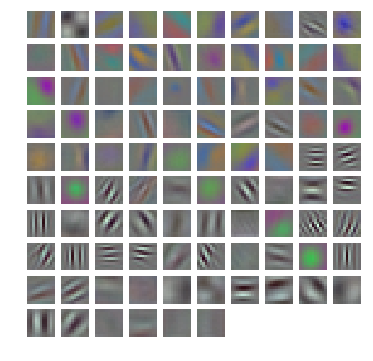

In [8]:
alex_w1 = alex_c12["conv1"][0]
print alex_w1.shape
mlutils.display_imgs(alex_w1)


### Vamos a usarlos como punto de partida para el entrenamiento de nuestra red

In [11]:
!wget https://s3.amazonaws.com/rlx/mini_cifar.h5

OSError: [Errno 12] Cannot allocate memory

In [ ]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

In [ ]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

In [ ]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [ ]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}



In [ ]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_C(num_classes)
model.summary()

## Transfer learning!!!

- Importamos el valor de los filtros de primer nivel


In [ ]:
w = model.get_weights()
for i in w:
    print i.shape

In [ ]:
w[0] = alex_w1
mlutils.display_imgs(w[0])

In [ ]:
model.set_weights(w)

In [ ]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

In [ ]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

observa que los filtros de primer nivel cambiaron, pero muy poco

In [ ]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

In [ ]:
mlutils.display_imgs(w[0])

In [ ]:
model.save("alexnet_finetuned_minicifar.model")

observe that you can also save separately the architecture

In [ ]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
!ls -lash alexnet_finetuned_minicifar*

In [ ]:
!head alexnet_finetuned_minicifar.architecture.json